In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.linear_model import LinearRegression
import os

# mpl.rc('image', interpolation='nearest', origin='lower')
%matplotlib inline

In [2]:
'''Data obtained by buat et al., 2018 using the
3DHST databse to include H-alpha emission
line along with photometric data'''

Data = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/COSMOS/CIGALE_file/help_MIPS_laigle_3dhst_cigale.fits', format = 'fits')

In [3]:
# Visualizing the first 5 objects to check columns and rows
# len(Data[np.where(Data['galex.NUV'] != -9999.99)])
# Data

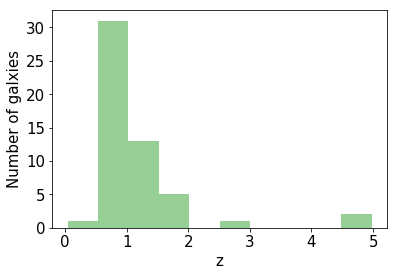

In [4]:
#Redshift distribution
plt.figure()
plt.hist(Data['redshift'], bins = 10, color = 'C2', alpha = 0.5)
plt.xlabel('z', fontsize = 15)
plt.ylabel('Number of galxies', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
# plt.savefig('1.png', dpi = 300, bbox_inches = 'tight')

In [5]:
'''Data retreived after applying the 
Calzetti and DBPL models to the final 
sample of objects in CIGALE'''

Calzetti_Ha  = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/COSMOS/CIGALE_file/\
Calzetti_Ha/out/results.txt', format = 'ascii')

DBPL_free_Ha = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/COSMOS/CIGALE_file/\
DBPL_Ha/out/results.txt', format = 'ascii')

Calzetti_vero  = Table.read('/home/jvilla/Documents/PhD_2018/Veronique_Test/Calzetti_like/out/results.txt',\
                     format = 'ascii')

DBPL_free_vero = Table.read('/home/jvilla/Documents/PhD_2018/Veronique_Test/DBPLfree/out/results.txt',\
                     format = 'ascii')

Calzetti_Hab  = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/COSMOS/CIGALE_file/\
Calzetti_Hab/out/results.txt', format = 'ascii')

DBPL_Hab = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/COSMOS/CIGALE_file/\
DBPL_Hab/out/results.txt', format = 'ascii')

In [6]:
#===================================================================================================================
'''Functions'''
#===================================================================================================================

#Main- relationSequence
#Schreiber et al., 2015
#https://www.aanda.org/articles/aa/pdf/2015/03/aa25017-14.pdf
def MS(z, M_star):
    r  = np.log10(1.0 + z)
    m  = np.log10(M_star / 10**9) #In M_sun^-1
    m0 = 0.5; a0 = 1.5; a1 = 0.3; m1 = 0.36; a2 = 2.5
    return (m - m0 + a0*r - a1*(np.maximum(0.0, m-m1-a2*r))**2)

#Relative uncertainty for division
#Data reduction and error analysis for physical sciences
#Phillip R. Bevignton and D. Keith Robinson
def Rel_uncertainty(Value, X, Y, X_err, Y_err):
    return np.sqrt(Value**2 * ((X_err/X)**2 + (Y_err/Y)**2) )

#Attenuation for a given line
#DBPL-like models
def A_line(A_v, Lambda, Lambda_v, n):
    return (A_v * (Lambda/Lambda_v)**n)

#Error in attenuation for a given line
#DBPL-free models
def Attenuation_DBPL_err(A_halpha, L, Lv, n, n_err, Av, Av_err):
    return (A_halpha)**2 * ((Av_err/Av)**2 + (n**2*(np.log(L/Lv))**2*n_err**2)/(L/Lv)**(2*n))

#Error in attenuation for a given line
#Calzetti-like models
def Calzetti_att_err(A_halpha, MW, MW_err, E_line, E_line_err):
    return (A_halpha)**2 * ((MW_err/MW)**2 + (E_line_err/E_line)**2)

#Power law exponent between two wavelengths (l and v)
def power_law_exponent(A_l, A_v, l, v):
    return (np.log(A_l/A_v) / np.log(l/v))

#Equation 10. chevallard et al., 2013
#Power law slope of the ISM in terms of Av (tau_v = 0.921 A_v)
def chevallard(A):
    return -(2.8 / (1.0 + 3.0*np.sqrt(0.921*A)))

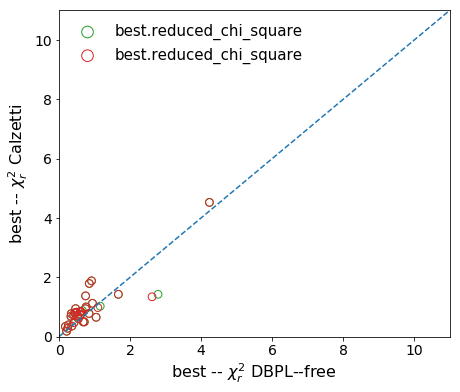

In [20]:
#===================================================================================================================
'''Reduced Chi-square'''
#===================================================================================================================

Line = np.linspace(0.0,11.0,100)

plt.figure(figsize = (7,6))
plt.scatter(DBPL_free_Ha['best.reduced_chi_square'], Calzetti_Ha['best.reduced_chi_square'],\
            marker = 'o', s = 60, facecolor = 'none', edgecolors = 'C2')
plt.scatter(DBPL_Hab['best.reduced_chi_square'], Calzetti_Hab['best.reduced_chi_square'],\
            marker = 'o', s = 60, facecolor = 'none', edgecolors = 'C3')
plt.plot(Line, Line, linestyle = '--')
plt.xlim(0.0, 11.0)
plt.ylim(0.0, 11.0)
plt.xlabel(r'best -- $\chi^2_r$ DBPL--free', fontsize = 16)
plt.ylabel(r'best -- $\chi^2_r$ Calzetti', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.5 , loc = 'upper left')

plt.savefig('3.png', dpi = 300, bbox_inches = 'tight')

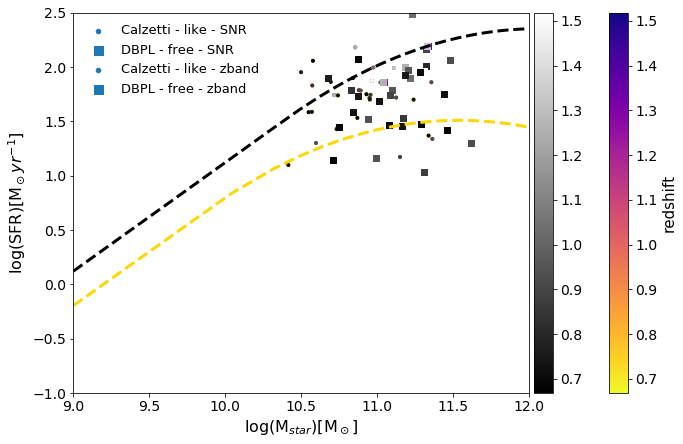

In [16]:
#===================================================================================================================
'''SFR versus stellar mass'''
#===================================================================================================================

M_star = np.linspace(10**9, 10**12, 100)

plt.figure(figsize = (10,7))
plt.scatter(np.log10(Calzetti_Ha['bayes.stellar.m_star']), np.log10(Calzetti_Ha['best.sfh.sfr']), marker = '.',\
           c = Calzetti_Ha['best.universe.redshift'], label ='Calzetti - like - SNR', cmap = plt.cm.plasma_r)
plt.scatter(np.log10(DBPL_free_Ha['bayes.stellar.m_star']), np.log10(DBPL_free_Ha['best.sfh.sfr']), marker = 's', \
           c = DBPL_free_Ha['best.universe.redshift'], label = 'DBPL - free - SNR', cmap = plt.cm.plasma_r)
cb = plt.colorbar(ticks = np.arange(0.6, 1.7, 0.1), fraction = 0.04, pad = 0.1)
cb.set_label(label = 'redshift', size = 15)
cb.ax.tick_params(labelsize = 14)

# plt.scatter(np.log10(Calzetti_vero['bayes.stellar.m_star']), np.log10(Calzetti_vero['best.sfh.sfr']), marker = '.',\
#            c = Calzetti_vero['best.universe.redshift'], label ='Calzetti - like- vero', cmap = plt.cm.binary_r)
# plt.scatter(np.log10(DBPL_free_vero['bayes.stellar.m_star']), np.log10(DBPL_free_vero['best.sfh.sfr']), marker = 's', \
#            c = DBPL_free_vero['best.universe.redshift'], label = 'DBPL - free - vero', cmap = plt.cm.binary_r)
# cb = plt.colorbar(ticks = np.arange(0.6, 1.7, 0.1), fraction = 0.04, pad = 0.01)
# cb.ax.tick_params(labelsize = 14)

plt.scatter(np.log10(Calzetti_Hab['bayes.stellar.m_star']), np.log10(Calzetti_Hab['best.sfh.sfr']), marker = '.',\
           c = Calzetti_Hab['best.universe.redshift'], label ='Calzetti - like - zband', cmap = plt.cm.binary_r)
plt.scatter(np.log10(DBPL_Hab['bayes.stellar.m_star']), np.log10(DBPL_Hab['best.sfh.sfr']), marker = 's', \
           c = DBPL_Hab['best.universe.redshift'], label = 'DBPL - free - zband', cmap = plt.cm.binary_r)
cb = plt.colorbar(ticks = np.arange(0.6, 1.7, 0.1), fraction = 0.04, pad = 0.01)
cb.ax.tick_params(labelsize = 14)

plt.plot(np.log10(M_star), MS(0.6,M_star), linestyle = '--', linewidth = 3.0, c = 'gold')
plt.plot(np.log10(M_star), MS(1.6,M_star), linestyle = '--', linewidth = 3.0, c = 'k')
plt.xlim(9, 12)
plt.ylim(-1.0, 2.5)
plt.xlabel(r'log(M$_{star}$)[M$_\odot$]', fontsize = 16)
plt.ylabel(r'log(SFR)[M$_\odot yr^{-1}$]', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.legend(frameon = False, prop = {'size': 13}, markerscale = 1.5 , loc = 'upper left')
# cb = plt.colorbar(ticks = np.arange(0.6, 1.7, 0.1), fraction = 0.04, pad = 0.01)
# cb.set_label(label = 'redshift', size = 15)
# cb.ax.tick_params(labelsize = 14)

plt.savefig('4.png', dpi = 300, bbox_inches = 'tight')

For SFR, Model slope:-0.084
For SFR, Model intercept:-0.050
For Mstar, Model slope:-0.012
For Mstar, Model intercept:0.128


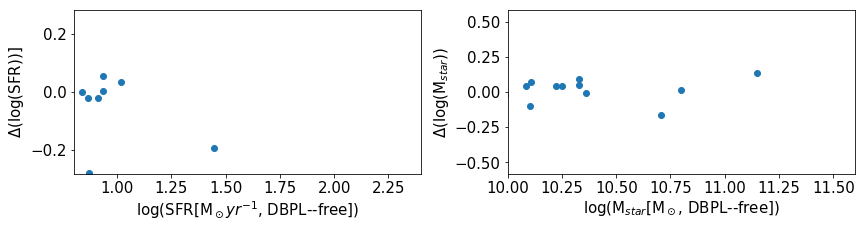

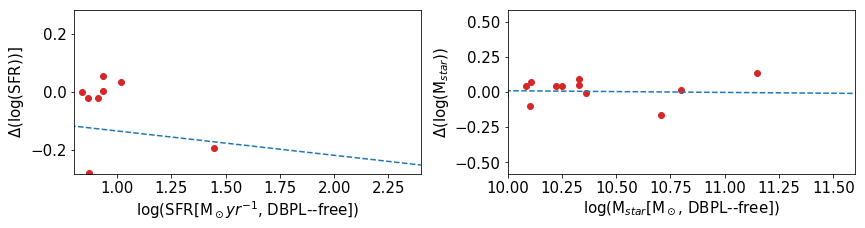

In [29]:
#===================================================================================================================
'''Regular plot'''
#===================================================================================================================

fig, ((axA, axB)) = plt.subplots(figsize = (14, 3), ncols = 2, nrows = 1)

#Delta SFR - SFR in the DBPL-free
axA.scatter(np.log10(DBPL_free['best.sfh.sfr']),\
            -np.log10(DBPL_free['best.sfh.sfr'])+np.log10(Calzetti['best.sfh.sfr']))
axA.set_ylabel(r'$\Delta$(log(SFR))]', fontsize = 15)
axA.set_xlabel('log(SFR[M$_\odot yr^{-1}$, DBPL--free])', fontsize = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 15)
axA.set_xlim(0.8,2.4)
axA.set_ylim(-0.28, 0.28)

#Delta Stellar mass - Stellar mass in the DBPL-free
axB.scatter(np.log10(DBPL_free['bayes.stellar.m_star']),\
            np.log10(DBPL_free['bayes.stellar.m_star'])-np.log10(Calzetti['bayes.stellar.m_star']))
axB.set_ylabel(r'$\Delta$(log(M$_{star}$))', fontsize = 15)
axB.set_xlabel('log(M$_{star}$[M$_\odot$, DBPL--free])', fontsize = 15)
axB.tick_params(axis = 'both', which = 'major', labelsize = 15)
axB.set_xlim(10.0,11.6)
axB.set_ylim(-0.58, 0.58)

plt.subplots_adjust(wspace = 0.25)

plt.savefig('5.png', dpi = 300, bbox_inches = 'tight')

#===================================================================================================================
'''Linear regression'''
#===================================================================================================================

#Data
X_1 = np.log10(DBPL_free['best.sfh.sfr'])
Y_1 = -np.log10(DBPL_free['best.sfh.sfr'])+np.log10(Calzetti['best.sfh.sfr'])

X_2 = np.log10(DBPL_free['bayes.stellar.m_star'])
Y_2 = np.log10(DBPL_free['bayes.stellar.m_star'])-np.log10(Calzetti['bayes.stellar.m_star'])

#Fit and prediction
model = LinearRegression(fit_intercept = True)

model.fit(X_1[:, np.newaxis], Y_1)
x_fit_1 = np.linspace(-1, 3, 100)
y_fit_1 = model.predict(x_fit_1[:, np.newaxis])

print("For SFR, Model slope:%.3f"%model.coef_[0])
print("For SFR, Model intercept:%.3f"%model.intercept_)

model.fit(X_2[:, np.newaxis], Y_2)
x_fit_2 = np.linspace(9, 12, 100)
y_fit_2 = model.predict(x_fit_2[:, np.newaxis])

print("For Mstar, Model slope:%.3f"%model.coef_[0])
print("For Mstar, Model intercept:%.3f"%model.intercept_)

#Plot with linear regression
fig, ((axA, axB)) = plt.subplots(figsize = (14, 3), ncols = 2, nrows = 1)

#Delta SFR - SFR in the DBPL-free
axA.scatter(np.log10(DBPL_free['best.sfh.sfr']),\
            -np.log10(DBPL_free['best.sfh.sfr'])+np.log10(Calzetti['best.sfh.sfr']), c = 'C3')
axA.plot(x_fit_1, y_fit_1, linestyle = '--')
axA.set_ylabel(r'$\Delta$(log(SFR))]', fontsize = 15)
axA.set_xlabel('log(SFR[M$_\odot yr^{-1}$, DBPL--free])', fontsize = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 15)
axA.set_xlim(0.8,2.4)
axA.set_ylim(-0.28, 0.28)

#Delta Stellar mass - Stellar mass in the DBPL-free
axB.scatter(np.log10(DBPL_free['bayes.stellar.m_star']),\
            np.log10(DBPL_free['bayes.stellar.m_star'])-np.log10(Calzetti['bayes.stellar.m_star']), c = 'C3')
axB.plot(x_fit_2, y_fit_2, linestyle = '--')
axB.set_ylabel(r'$\Delta$(log(M$_{star}$))', fontsize = 15)
axB.set_xlabel('log(M$_{star}$[M$_\odot$, DBPL--free])', fontsize = 15)
axB.tick_params(axis = 'both', which = 'major', labelsize = 15)
axB.set_xlim(10.0,11.6)
axB.set_ylim(-0.58, 0.58)

plt.subplots_adjust(wspace = 0.25)

plt.savefig('6.png', dpi = 300, bbox_inches = 'tight')

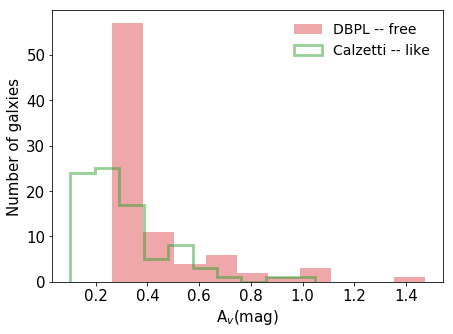

In [30]:
#===================================================================================================================
'''Distribution of total attenuation'''
#===================================================================================================================

plt.figure(figsize = (7, 5))
plt.hist(DBPL_free['best.attenuation.V_B90'], bins = 10, histtype = 'stepfilled',\
         linewidth = 0.2, color = 'C3', alpha = 0.4, align = 'right', label = 'DBPL -- free')
plt.hist(Calzetti['best.attenuation.V_B90'], bins = 10, histtype = 'step',\
         linewidth = 2.8, color = 'C2', alpha = 0.5, align = 'right', label = 'Calzetti -- like')
plt.xlabel(r'A$_v$(mag)', fontsize = 15)
plt.ylabel('Number of galxies', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 14}, markerscale = 1.5 , loc = 'upper right')

plt.savefig('7.png', dpi = 300, bbox_inches = 'tight')

In [12]:
#===================================================================================================================
'''Likelihood distributions for three mock datasets'''
#===================================================================================================================

#http://dfm.io/george/current/user/model/

'Likelihood distributions for three mock datasets'

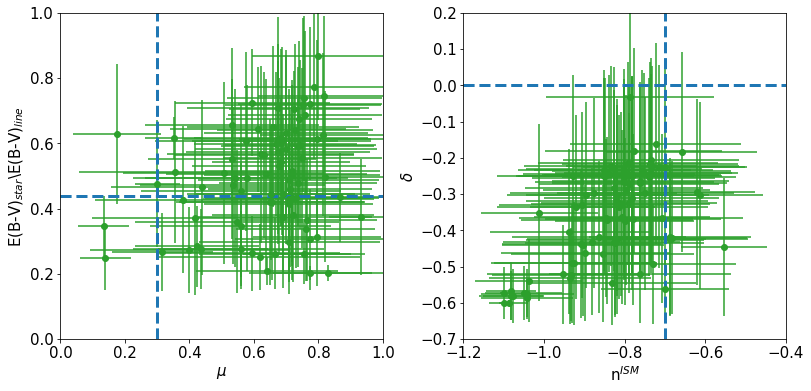

In [31]:
#===================================================================================================================
'''Attenuation Law Parameters'''
#===================================================================================================================

x_err = DBPL_free['bayes.attenuation.mu_err']
y_err = Calzetti['bayes.attenuation.E_BV_factor_err']

x_err_1 = DBPL_free['bayes.attenuation.slope_ISM_err']
y_err_1 = Calzetti['bayes.attenuation.powerlaw_slope_err']

fig, ((axA, axB)) = plt.subplots(figsize = (13, 6), ncols = 2, nrows = 1)

#Differential attenuation mu versus E(B-V)star/E(B-V)line
axA.errorbar(DBPL_free['bayes.attenuation.mu'], Calzetti['bayes.attenuation.E_BV_factor'],\
             y_err, x_err, c = 'C2', fmt = 'o')
axA.axvline(0.30, linestyle = '--', linewidth = 3)
axA.axhline(0.44, linestyle = '--', linewidth = 3)
axA.set_xlabel(r'$\mu$', fontsize = 15)
axA.set_ylabel(r'E(B-V)$_{star}$\E(B-V)$_{line}$', fontsize = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 15)
axA.set_xlim(0.0,1.0)
axA.set_ylim(0.0, 1.0)

#Slopes: delta for Calzetti-like and n^ISM for DBPL-free
# axB.scatter(DBPL_free['bayes.attenuation.slope_ISM'], Calzetti['bayes.attenuation.powerlaw_slope'])
axB.errorbar(DBPL_free['bayes.attenuation.slope_ISM'], Calzetti['bayes.attenuation.powerlaw_slope'],\
            y_err_1, x_err_1, c = 'C2', fmt = 'o')
axB.axvline(-0.7, linestyle = '--', linewidth = 3)
axB.axhline(0.0, linestyle = '--', linewidth = 3)
axB.set_xlabel(r'n$^{ISM}$', fontsize = 15)
axB.set_ylabel(r'$\delta$', fontsize = 15)
axB.tick_params(axis = 'both', which = 'major', labelsize = 15)
axB.set_xlim(-1.2, -0.4)
axB.set_ylim(-0.7, 0.2)

plt.subplots_adjust(wspace = 0.25)

plt.savefig('8.png', dpi = 300, bbox_inches = 'tight')

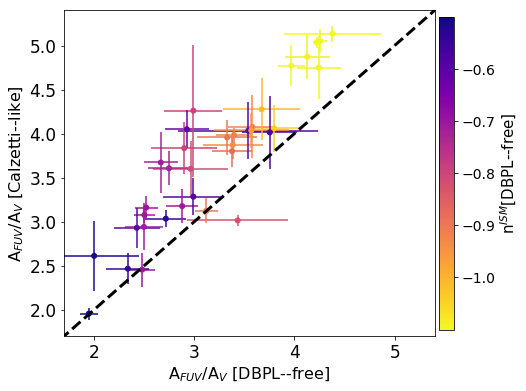

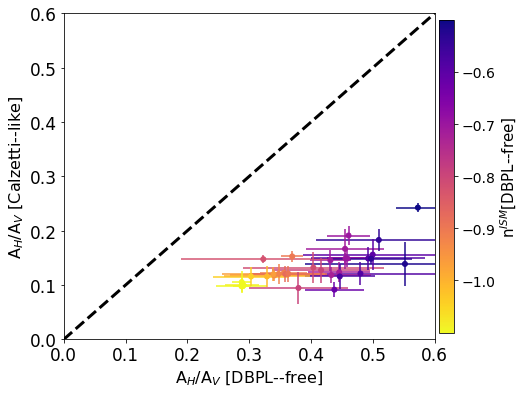

In [14]:
#===================================================================================================================
'''SFR versus stellar mass'''
#===================================================================================================================

Line = np.linspace(0.0,9.0,100)

x_err = Rel_uncertainty((DBPL_free['bayes.attenuation.FUV']/DBPL_free['bayes.attenuation.V_B90']),\
                       DBPL_free['bayes.attenuation.FUV'], DBPL_free['bayes.attenuation.V_B90'],\
                       DBPL_free['bayes.attenuation.FUV_err'], DBPL_free['bayes.attenuation.V_B90_err'])
y_err = Rel_uncertainty((Calzetti['bayes.attenuation.FUV']/Calzetti['bayes.attenuation.V_B90']),\
                       Calzetti['bayes.attenuation.FUV'], Calzetti['bayes.attenuation.V_B90'],\
                       Calzetti['bayes.attenuation.FUV_err'], Calzetti['bayes.attenuation.V_B90_err'])

x_err_1 = Rel_uncertainty((DBPL_free['bayes.attenuation.2mass.H']/DBPL_free['bayes.attenuation.V_B90']),\
                          DBPL_free['bayes.attenuation.2mass.H'],DBPL_free['bayes.attenuation.V_B90'],\
                          DBPL_free['bayes.attenuation.2mass.H_err'],DBPL_free['bayes.attenuation.V_B90_err'])
y_err_1 = Rel_uncertainty((Calzetti['bayes.attenuation.2mass.H']/Calzetti['bayes.attenuation.V_B90']),\
                          Calzetti['bayes.attenuation.2mass.H'],Calzetti['bayes.attenuation.V_B90'],\
                          Calzetti['bayes.attenuation.2mass.H_err'],Calzetti['bayes.attenuation.V_B90_err'])

plt.figure(figsize = (7,6))

sc = plt.scatter(DBPL_free['bayes.attenuation.FUV']/DBPL_free['bayes.attenuation.V_B90'], \
           Calzetti['bayes.attenuation.FUV']/Calzetti['bayes.attenuation.V_B90'], marker = '.',\
           s = 100, c = DBPL_free['bayes.attenuation.slope_ISM'], cmap = plt.cm.plasma_r)
a,b,c = plt.errorbar(DBPL_free['bayes.attenuation.FUV']/DBPL_free['bayes.attenuation.V_B90'], \
           Calzetti['bayes.attenuation.FUV']/Calzetti['bayes.attenuation.V_B90'],\
           y_err, x_err, marker = '', ls = '', zorder = 0)
plt.plot(Line, Line, ls = '--', lw = 3, c = 'k')
plt.xlim(1.7, 5.4)
plt.ylim(1.7, 5.4)
plt.xlabel(r'A$_{FUV}$/A$_{V}$ [DBPL--free]', fontsize = 16)
plt.ylabel(r'A$_{FUV}$/A$_{V}$ [Calzetti--like]', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
clb = plt.colorbar(sc, ticks = np.arange(-1.0, -0.5, 0.1), fraction = 0.04, pad = 0.01)
clb.set_label(label = r'n$^{ISM}$[DBPL--free]', size = 15)
clb.ax.tick_params(labelsize = 14)
color = clb.to_rgba(DBPL_free['bayes.attenuation.slope_ISM'])
c[0].set_color(color)
c[1].set_color(color)

plt.savefig('9.png', dpi = 300, bbox_inches = 'tight')

plt.figure(figsize = (7,6))

sc = plt.scatter(DBPL_free['bayes.attenuation.2mass.H']/DBPL_free['bayes.attenuation.V_B90'], \
           Calzetti['bayes.attenuation.2mass.H']/Calzetti['bayes.attenuation.V_B90'], marker = '.',\
           s = 100, c = DBPL_free['bayes.attenuation.slope_ISM'], cmap = plt.cm.plasma_r)
a,b,c = plt.errorbar(DBPL_free['bayes.attenuation.2mass.H']/DBPL_free['bayes.attenuation.V_B90'], \
           Calzetti['bayes.attenuation.2mass.H']/Calzetti['bayes.attenuation.V_B90'],\
           y_err_1, x_err_1, marker = '', ls = '', zorder = 0)
plt.plot(Line, Line, ls = '--', lw = 3, c = 'k')
plt.xlim(0.0, 0.6)
plt.ylim(0.0, 0.6)
plt.xlabel(r'A$_{H}$/A$_{V}$ [DBPL--free]', fontsize = 16)
plt.ylabel(r'A$_{H}$/A$_{V}$ [Calzetti--like]', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
clb = plt.colorbar(sc, ticks = np.arange(-1.0, -0.5, 0.1), fraction = 0.04, pad = 0.01)
clb.set_label(label = r'n$^{ISM}$[DBPL--free]', size = 15)
clb.ax.tick_params(labelsize = 14)
color = clb.to_rgba(DBPL_free['bayes.attenuation.slope_ISM'])
c[0].set_color(color)
c[1].set_color(color)

plt.savefig('10.png', dpi = 300, bbox_inches = 'tight')

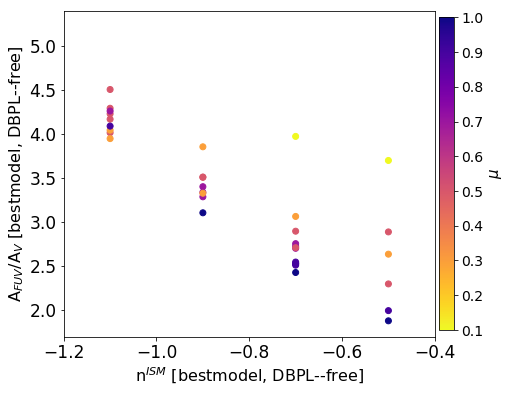

In [15]:
#===================================================================================================================
'''Ratio of the attenuation FUV-V versus n^ISM'''
#===================================================================================================================

plt.figure(figsize = (7,6))
plt.scatter(DBPL_free['best.attenuation.slope_ISM'], \
            DBPL_free['best.attenuation.FUV']/DBPL_free['best.attenuation.V_B90'],\
            c = DBPL_free['best.attenuation.mu'], marker = 'o', cmap = plt.cm.plasma_r)
plt.xlim(-1.2, -0.4)
plt.ylim(1.7, 5.4)
plt.xlabel(r'n$^{ISM}$ [bestmodel, DBPL--free]', fontsize = 16)
plt.ylabel(r'A$_{FUV}$/A$_{V}$ [bestmodel, DBPL--free]', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
cb = plt.colorbar(ticks = np.arange(0.1, 1.1, 0.1), fraction = 0.04, pad = 0.01)
cb.set_label(label = r'$\mu$', size = 15)
cb.ax.tick_params(labelsize = 14)

plt.savefig('11.png', dpi = 300, bbox_inches = 'tight')

In [16]:
#Files corresponding to the observed data (3D-HST)

DBPL_free_obs = Table.read('/home/jvilla/Documents/PhD_2018/Veronique_Test/DBPLfree/out/observations.txt', format = 'ascii')
Calzetti_obs  = Table.read('/home/jvilla/Documents/PhD_2018/Veronique_Test/Calzetti_like/out/observations.txt', format = 'ascii')

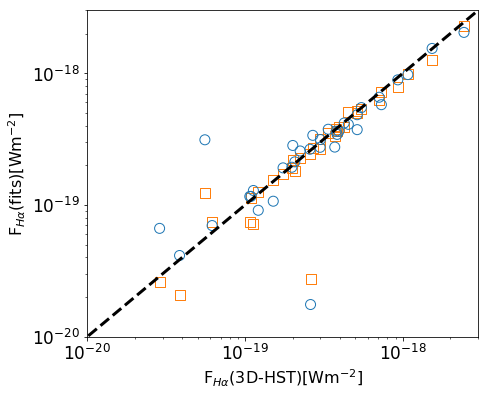

In [17]:
#===================================================================================================================
'''H_alpha flux comaprison for observed and model data'''
#===================================================================================================================

Line = np.linspace(0.0,9.0,100)

plt.figure(figsize = (7,6))
plt.scatter(DBPL_free_obs['line.NII-654.8+line.H-alpha+line.NII-658.4'],\
            DBPL_free['bayes.line.NII-654.8+line.H-alpha+line.NII-658.4'], marker ='s', s = 100,
            facecolor = 'none', edgecolors = 'C1')
plt.scatter(Calzetti_obs['line.NII-654.8+line.H-alpha+line.NII-658.4'],\
            Calzetti['bayes.line.NII-654.8+line.H-alpha+line.NII-658.4'], marker = 'o', s = 100,
            facecolor = 'none', edgecolors = 'C0')
plt.plot(Line, Line, ls = '--', lw = 3, c = 'k')
plt.xlim(1e-20, 3e-18)
plt.ylim(1e-20, 3e-18)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'F$_{H\alpha}$(3D-HST)[Wm$^{-2}$]', fontsize = 16)
plt.ylabel(r'F$_{H\alpha}$(fits)[Wm$^{-2}$]', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)

plt.savefig('12.png', dpi = 300, bbox_inches = 'tight')

The mean values of DBPL--free is: 2.39
The mean values of Calzetti--like is: 2.17


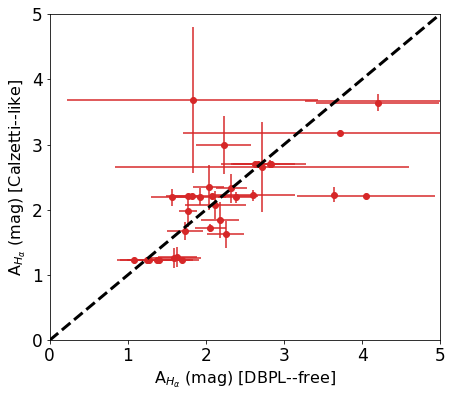

In [18]:
#===================================================================================================================
'''H_alpha flux comaprison for observed and model data'''
#===================================================================================================================

#A_Halpha (0.63 micrometers) for DBPL--free
A_BC   = A_line(A_v = DBPL_free['bayes.attenuation.Av_BC'], Lambda = 0.63, Lambda_v = 0.55,\
                n = DBPL_free['bayes.attenuation.slope_BC'])
A_ISM  = A_line(A_v = DBPL_free['bayes.attenuation.Av_ISM'], Lambda = 0.63, Lambda_v = 0.55,\
                n = DBPL_free['bayes.attenuation.slope_ISM'])
A_DBPL = A_BC + A_ISM

#A_Halpha (0.63 micrometers) for Calzetti--like
Milky_Way  = 2.45
A_Calzetti = Milky_Way*Calzetti['bayes.attenuation.E_BV_lines']

print('The mean values of DBPL--free is: %0.2f'%np.mean(A_DBPL))
print('The mean values of Calzetti--like is: %0.2f'%np.mean(A_Calzetti))

#Errors
DBPL_x_err_BC  = Attenuation_DBPL_err(A_BC, L = 0.65, Lv = 0.55, n = DBPL_free['bayes.attenuation.slope_BC'],\
                                     n_err = DBPL_free['bayes.attenuation.slope_BC_err'],\
                                     Av = DBPL_free['bayes.attenuation.Av_BC'],\
                                     Av_err = DBPL_free['bayes.attenuation.Av_BC_err'])
DBPL_x_err_ISM = Attenuation_DBPL_err(A_ISM, L = 0.65, Lv = 0.55, n = DBPL_free['bayes.attenuation.slope_ISM'],\
                                     n_err = DBPL_free['bayes.attenuation.slope_ISM_err'],\
                                     Av = DBPL_free['bayes.attenuation.Av_ISM'],\
                                     Av_err = DBPL_free['bayes.attenuation.Av_ISM_err'])
x_err_tot = np.sqrt(DBPL_x_err_BC + DBPL_x_err_ISM)

Calzetti_y_err = Calzetti_att_err(A_Calzetti, Milky_Way, 0.01, Calzetti['bayes.attenuation.E_BV_lines'], Calzetti['bayes.attenuation.E_BV_lines_err'])
y_err_tot = np.sqrt(Calzetti_y_err)

plt.figure(figsize = (7,6))
plt.errorbar(A_DBPL, A_Calzetti, y_err_tot, x_err_tot, c = 'C3', marker = 'o', ls = '', zorder = 0)
plt.plot(Line, Line, ls = '--', lw = 3, c = 'k')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel(r'A$_{H_\alpha}$ (mag) [DBPL--free]', fontsize = 16)
plt.ylabel(r'A$_{H_\alpha}$ (mag) [Calzetti--like]', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)

plt.savefig('12_1.png', dpi = 300, bbox_inches = 'tight')

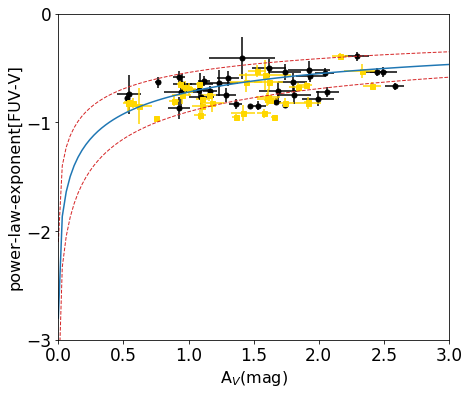

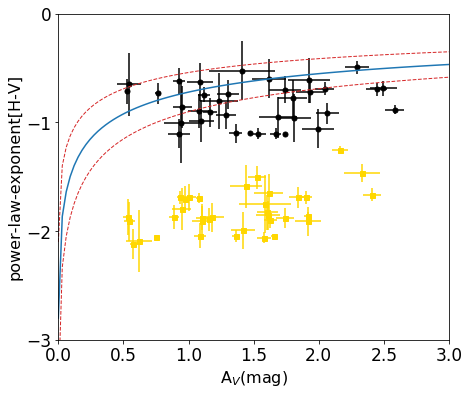

In [19]:
#===================================================================================================================
'''Power-law exponent versus attenuation in V-band'''
#===================================================================================================================

Av_chevallard = np.linspace(0, 3, 100)
FUV = 0.10 #in micrometers
V   = 0.55 #in micrometers
H   = 1.70 #in micrometers

#Errors
x_err_dbpl     = DBPL_free['bayes.attenuation.V_B90_err']
x_err_calzetti = Calzetti['bayes.attenuation.V_B90_err']

y_err_dbpl     = np.sqrt((1.0/np.log(FUV/V)**2) * \
                 (DBPL_free['bayes.attenuation.FUV_err']/DBPL_free['bayes.attenuation.FUV'])**2 +\
                 (DBPL_free['bayes.attenuation.V_B90_err']/DBPL_free['bayes.attenuation.V_B90'])**2) 
y_err_calzetti = np.sqrt((1.0/np.log(FUV/V)**2) * \
                 (Calzetti['bayes.attenuation.FUV_err']/Calzetti['bayes.attenuation.FUV'])**2 +\
                 (Calzetti['bayes.attenuation.V_B90_err']/Calzetti['bayes.attenuation.V_B90'])**2)

plt.figure(figsize = (7,6))
plt.errorbar(DBPL_free['bayes.attenuation.V_B90'],\
           power_law_exponent(DBPL_free['bayes.attenuation.FUV'], DBPL_free['bayes.attenuation.V_B90'],\
           FUV, V), y_err_dbpl, x_err_dbpl, c = 'k', marker = 'o', ms = 5, ls = '', zorder = 0)
plt.errorbar(Calzetti['bayes.attenuation.V_B90'],\
           power_law_exponent(Calzetti['bayes.attenuation.FUV'], Calzetti['bayes.attenuation.V_B90'],\
           FUV, V), y_err_calzetti, x_err_calzetti, c = 'gold', marker = 's', ms = 5, ls = '', zorder = 0)
plt.plot(Av_chevallard, chevallard(Av_chevallard), c = 'C0', ls ='-', lw = 1.5)
plt.plot(Av_chevallard, chevallard(Av_chevallard)+0.25*chevallard(Av_chevallard), c = 'C3', ls ='--', lw = 1)
plt.plot(Av_chevallard, chevallard(Av_chevallard)-0.25*chevallard(Av_chevallard), c = 'C3', ls ='--', lw = 1)

plt.xlim(0, 3)
plt.ylim(-3, 0)
plt.xlabel(r'A$_{V}$(mag)', fontsize = 16)
plt.ylabel(r'power-law-exponent[FUV-V]', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.xticks(np.arange(0, 3.5, step = 0.5))
plt.yticks(np.arange(-3, 0.5, step = 1.0))

plt.savefig('13.png', dpi = 300, bbox_inches = 'tight')


#Errors
x_err_dbpl_1     = DBPL_free['bayes.attenuation.V_B90_err']
x_err_calzetti_1 = Calzetti['bayes.attenuation.V_B90_err']

y_err_dbpl_1     = np.sqrt((1.0/np.log(H/V)**2) * \
                 (DBPL_free['bayes.attenuation.2mass.H_err']/DBPL_free['bayes.attenuation.2mass.H'])**2 +\
                 (DBPL_free['bayes.attenuation.V_B90_err']/DBPL_free['bayes.attenuation.V_B90'])**2) 
y_err_calzetti_1 = np.sqrt((1.0/np.log(H/V)**2) * \
                 (Calzetti['bayes.attenuation.2mass.H_err']/Calzetti['bayes.attenuation.2mass.H'])**2 +\
                 (Calzetti['bayes.attenuation.V_B90_err']/Calzetti['bayes.attenuation.V_B90'])**2)

plt.figure(figsize = (7,6))
plt.errorbar(DBPL_free['bayes.attenuation.V_B90'],\
           power_law_exponent(DBPL_free['bayes.attenuation.2mass.H'], DBPL_free['bayes.attenuation.V_B90'],\
           H, V), y_err_dbpl_1, x_err_dbpl_1, c = 'k', marker = 'o', ms = 5, ls = '', zorder = 0)
plt.errorbar(Calzetti['bayes.attenuation.V_B90'],\
           power_law_exponent(Calzetti['bayes.attenuation.2mass.H'], Calzetti['bayes.attenuation.V_B90'],\
           H, V), y_err_calzetti_1, x_err_calzetti_1, c = 'gold', marker = 's', ms = 5, ls = '', zorder = 0)
plt.plot(Av_chevallard, chevallard(Av_chevallard), c = 'C0', ls ='-', lw = 1.5)
plt.plot(Av_chevallard, chevallard(Av_chevallard)+0.25*chevallard(Av_chevallard), c = 'C3', ls ='--', lw = 1)
plt.plot(Av_chevallard, chevallard(Av_chevallard)-0.25*chevallard(Av_chevallard), c = 'C3', ls ='--', lw = 1)

plt.xlim(0, 3)
plt.ylim(-3, 0)
plt.xlabel(r'A$_{V}$(mag)', fontsize = 16)
plt.ylabel(r'power-law-exponent[H-V]', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.xticks(np.arange(0, 3.5, step = 0.5))
plt.yticks(np.arange(-3, 0.5, step = 1.0))

plt.savefig('13_1.png', dpi = 300, bbox_inches = 'tight')

In [20]:
#Moving all the plots to a new folder
os.system('mv /home/jvilla/Documents/PhD_2018/Veronique_Test/*.png /home/jvilla/Documents/PhD_2018/Veronique_Test/Figures')

0

In [3]:
SED = Table.read('/home/jvilla/Documents/PhD_2018/Veronique_Test/Calzetti_like/out/HELP_J100044.58+022231.03_best_model.fits', format = 'fits')

In [9]:
#SEDs

SED[:1]

wavelength,Fnu,L_lambda_total,stellar.old,stellar.young,nebular.absorption_old,nebular.absorption_young,nebular.lines_old,nebular.lines_young,nebular.continuum_old,nebular.continuum_young,attenuation.stellar.old,attenuation.stellar.young,attenuation.nebular.lines_old,attenuation.nebular.lines_young,attenuation.nebular.continuum_old,attenuation.nebular.continuum_young,dust.Umin_Umin,dust.Umin_Umax,igm
nm,mJy,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm,W / nm
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
15.320760077238083,0.0,0.0,2.555702599453251e+31,2.890196215536619e+32,-2.555702599453251e+31,-2.890196215536619e+32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


(0.2, 1000000.0)

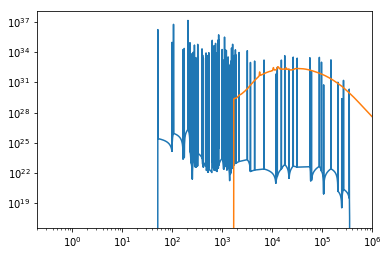

In [29]:
plt.figure()
plt.plot(SED['wavelength'], SED['nebular.lines_young'])
plt.plot(SED['wavelength'], SED['dust.Umin_Umax'])
plt.plot(SED['wavelength'], SED['nebular.absorption_young'])
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.2, 1e6)